In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import make_pipeline
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

df = pd.read_excel("Data.xlsx")
review_column = 'Review'
nlp = spacy.load("en_core_web_sm") #preprocessing the data

def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and token.lemma_.lower() not in STOP_WORDS]
    return " ".join(tokens)

df['processed_reviews'] = df[review_column].apply(preprocess)

# CountVectorizer and LDA for topic modeling
vectorizer = CountVectorizer(max_df=0.85, stop_words='english')
lda = LatentDirichletAllocation(n_components=5, random_state=42)

model = make_pipeline(vectorizer, lda)

#MOdel fittting
document_term_matrix = model.fit_transform(df['processed_reviews'])

# Getting the dominant topic for each review
df['dominant_topic'] = document_term_matrix.argmax(axis=1)

topic_counts = df['dominant_topic'].value_counts()
print("Topic Occurrence:")
print(topic_counts)

feature_names = vectorizer.get_feature_names_out()
topic_keywords = []

for topic_weights in lda.components_:
    top_keyword_indices = topic_weights.argsort()[:-10 - 1:-1]
    topic_keywords.append([feature_names[i] for i in top_keyword_indices])

print("\nTop Keywords for Each Topic:")
for i, keywords in enumerate(topic_keywords):
    print(f"Topic {i}: {', '.join(keywords)}")


Topic Occurrence:
4    2568
1    2519
0    1677
3    1447
2     965
Name: dominant_topic, dtype: int64

Top Keywords for Each Topic:
Topic 0: good, excellent, friendly, service, room, user, stay, staff, clean, breakfast
Topic 1: use, app, easy, bank, banking, step, verification, bad, account, love
Topic 2: great, app, nice, awesome, work, experience, convenient, banking, thank, problem
Topic 3: work, deposit, app, cheque, update, time, try, fix, issue, check
Topic 4: app, account, phone, work, log, time, try, sign, update, crash


Top Trigrams and Their Frequencies:
good easy use: 11.197587803539049
super easy use: 10.198704232472645
step verification work: 9.21257738891007
try deposit cheque: 8.200050821487087
deposit cheque work: 8.19847619047662
activate step verification: 7.206541100325756
app work fine: 7.202573550611335
picture cheque deposit: 6.207104139018346
set step verification: 6.2028719077754815
step verification process: 5.214779932078592
force step verification: 5.211739893014795
app easy navigate: 5.205589049833503
app work great: 5.204955246014284
photo cheque deposit: 5.2003433957345395
easy use good: 4.221223935319721
impossible deposit cheque: 4.212508722481727
app stop work: 4.211830329958042
bad banking app: 4.204271011106613
cheque deposit feature: 4.2036271638839064
absolute garbage app: 4.199964052954749


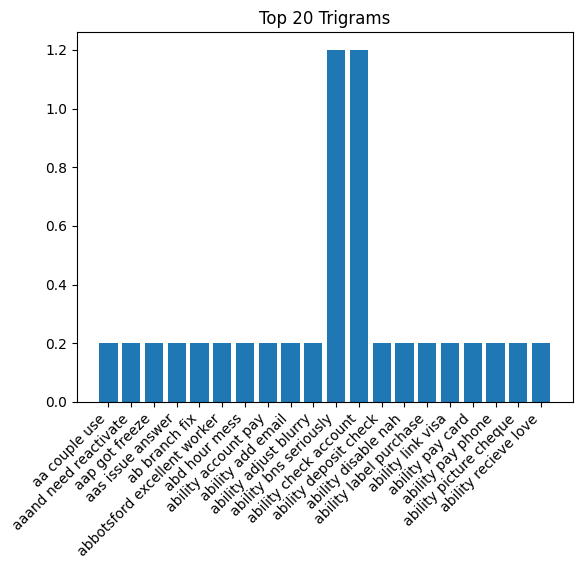

In [ ]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")

excel_file_path = '/content/Data.xlsx'
df = pd.read_excel(excel_file_path)

text_column_name = 'Review'

def preprocess(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in STOP_WORDS]
    return " ".join(tokens)

df['processed_reviews'] = df[text_column_name].apply(preprocess)

vectorizer = CountVectorizer(ngram_range=(3, 3))
trigram_matrix = vectorizer.fit_transform(df['processed_reviews'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_matrix = lda.fit_transform(trigram_matrix)

feature_names = vectorizer.get_feature_names_out()
trigram_frequencies = zip(feature_names, lda.components_[0])
sorted_trigrams = sorted(trigram_frequencies, key=lambda x: x[1], reverse=True)

print("Top Trigrams and Their Frequencies:")
for trigram, frequency in sorted_trigrams[:20]:
    print(f"{trigram}: {frequency}")

plt.bar(range(20), lda.components_[0][:20], tick_label=feature_names[:20])
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Trigrams')
plt.show()


Streaming output truncated to the last 5000 lines.
Group 4176: ["Thanks for such a great expierence.just 5star all in..thanks don't change a thing.keep up the great work.great rates.i stay in 7hotels this week, and u r the best.                  "]
Group 4177: ['Awesome app', 'Awesome having this app.', 'Awesome app very easy to use 🙂👍', 'awesome app', 'Very convenient, Awesome app👍👍', 'Awesome app. Never glitches.', 'Awesome app', 'Awesome app. :)', 'Awesome app', 'Awesome bank and app', 'Awesome app', 'Awesome app', 'Awesome App', 'Awesome App to Manage Money', 'Awesome app very easy to use', 'Awesome app', 'Great app and awesome service.', 'Always courteous and mobile app is awesome!', 'Awesome app!', 'app works awesome']
Group 4178: ["It's fine for the most part. Wish scene was more accessible well easier to use, It's such a long drawn out process. Points could be much better."]
Group 4179: ["Been having nothing but issues lately. Today I can't sign in to my app or account on the w

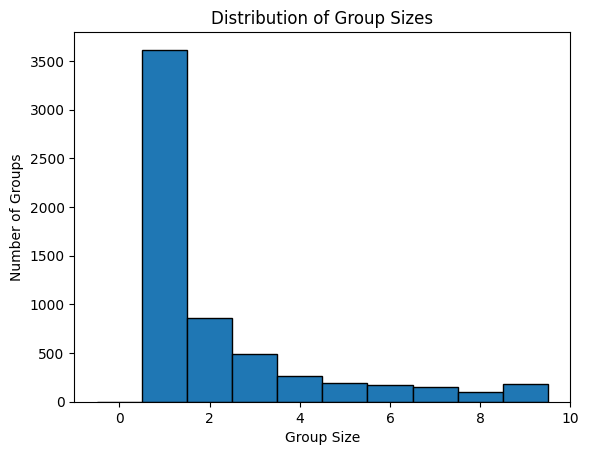

In [ ]:
!pip install datasketch
import pandas as pd
import spacy
from datasketch import MinHash, MinHashLSH
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load data
excel_file_path = '/content/Data.xlsx'
df = pd.read_excel(excel_file_path)

# Specify the column containing reviews
text_column_name = 'Review'

# Preprocess the data
def preprocess(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in nlp.Defaults.stop_words]
    return " ".join(tokens)

df['processed_reviews'] = df[text_column_name].apply(preprocess)

# Create MinHash for each review
minhash_list = []
for _, row in df.iterrows():
    text = row['processed_reviews']
    minhash = MinHash()
    for word in text.split():
        minhash.update(word.encode('utf-8'))
    minhash_list.append(minhash)

# Create an LSH index
lsh = MinHashLSH(threshold=0.5, num_perm=128)

# Index the reviews
for i, minhash in enumerate(minhash_list):
    lsh.insert(i, minhash)

# Group similar reviews
groups = {}
for i, minhash in enumerate(minhash_list):
    results = lsh.query(minhash)
    groups[i] = results

# Display the groups
for group_id, review_ids in groups.items():
    print(f"Group {group_id}: {[df.loc[idx, 'Review'] for idx in review_ids]}")

# Plot the distribution of groups
plt.hist(list(map(len, groups.values())), bins=range(11), align='left', edgecolor='black')
plt.xlabel('Group Size')
plt.ylabel('Number of Groups')
plt.title('Distribution of Group Sizes')
plt.show()


In [18]:
!pip install bertopic
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic

excel_file_path = '/content/Data.xlsx'
df = pd.read_excel(excel_file_path)

text_column_name = 'Review'

df['processed_reviews'] = df[text_column_name].apply(preprocess)

model = BERTopic()
topics, _ = model.fit_transform(df['processed_reviews'])

df['topic'] = topics

print("Review and Assigned Topic:")
for review, topic in zip(df['Review'], df['topic']):
    print(f"Review: {review[:50]}... Topic: {topic}")

model.visualize_topics()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 13.8 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.3 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039271 sha256=87eabecde31f07fca105c61fc36770ddd4dd85a9cdfa39080b71a60b43b59338
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
  Created wheel for umap-

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
Review: Thanks for such a great expierence.just 5star all ... Topic: 3
Review: Awesome App... Topic: 94
Review: It's fine for the most part. Wish scene was more a... Topic: 27
Review: Been having nothing but issues lately. Today I can... Topic: 1
Review: the best bank i have ever seen... Topic: 72
Review: Transaction taking too long... Topic: 66
Review: Crashes frequently... Topic: 148
Review: Love the apps... Topic: 44
Review: Version 20.41.0 should be revoked. Can only sign-i... Topic: 29
Review: Great 👍... Topic: 5
Review: It isn't any good at all... Topic: 2
Review: Can't login without signing up to two factor authe... Topic: 1
Review: Is the app working or not..... Error message: "Sor... Topic: -1
Review: Auto picture too fast before chq image steadied... Topic: 0
Review: This hotewl is very old and needs upgrading. Room ... Topic: 3
Review: The app is okay, the speed of transactions leaves ... Topic: 66
Review: I was sent a legal

In [24]:
import pandas as pd
from bertopic import BERTopic

# Load data
excel_file_path = '/content/Data.xlsx'
df = pd.read_excel(excel_file_path)

# Specify the column containing reviews
text_column_name = 'Review'

# Preprocess the data (if needed)
df['processed_reviews'] = df[text_column_name].apply(preprocess)

# Use BERTopic for topic modeling
model = BERTopic()
topics, _ = model.fit_transform(df['processed_reviews'])

# Manually set the number of topics
model.num_topics = 10

# Assign topic labels to each review
df['topic'] = topics

# Get readable topics
topics_info = model.get_topics()

# Map topic IDs to readable topics
df['readable_topic'] = df['topic'].map({topic_id: topic_info[0] for topic_id, topic_info in topics_info.items()})

# Display reviews along with their assigned readable topics
print("Review and Assigned Readable Topic:")
for review, readable_topic in zip(df['Review'], df['readable_topic']):
    print(f"Review: {review[:50]}... Readable Topic: {readable_topic}")

# Save the DataFrame with readable topic labels (if needed)
df.to_excel('/content/Data_with_readable_topics.xlsx', index=False)


Streaming output truncated to the last 5000 lines.
Review: Thanks for such a great expierence.just 5star all ... Readable Topic: ('room', 0.05438428848952171)
Review: Awesome App... Readable Topic: ('awesome', 0.4057298394896589)
Review: It's fine for the most part. Wish scene was more a... Readable Topic: ('account', 0.008373549241678583)
Review: Been having nothing but issues lately. Today I can... Readable Topic: ('verification', 0.029185028874940948)
Review: the best bank i have ever seen... Readable Topic: ('bank', 0.1486733864860963)
Review: Transaction taking too long... Readable Topic: ('transaction', 0.18427092326813171)
Review: Crashes frequently... Readable Topic: ('crash', 0.19008891931745592)
Review: Love the apps... Readable Topic: ('love', 0.2538446887780097)
Review: Version 20.41.0 should be revoked. Can only sign-i... Readable Topic: ('sign', 0.07796707352407242)
Review: Great 👍... Readable Topic: ('great', 0.3687440545164954)
Review: It isn't any good at all... Readab